In [1]:
cd ..

/home/mars/Documents/phd_code/src_aiai


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from src.operators.measurement import NUFFT_op, NUFFT_op_TF, calculate_kaiser_bessel_coef
from src.sampling.uv_sampling import spider_sampling
import tqdm
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

Failed to import NUDFT_cupy (experimental). Use NUDFT() instead. 


In [3]:
 Nd, Kd, Jd = (256,256), (512,512), (6,6)

In [4]:
class TF_nufft(NUFFT_op):
    """ Tensorfow adaptation of the nufft operator""" 
    def forward(self, x):
        return tf.numpy_function(self.dir_op, [x], tf.complex64)

    def adjoint(self, x):
        return tf.numpy_function(self.adj_op, [x], tf.complex64)

In [5]:
class Gradient(tf.keras.layers.Layer):
    def __init__(self, m_op, shape_x, shape_y, depth, learned=False):
        self.m_op = m_op
        self.learned = learned
        self.input_spec = [
            tf.keras.layers.InputSpec(
                dtype=tf.float32,
                shape=shape_x
            ),
            tf.keras.layers.InputSpec(
                dtype=tf.complex64,
                shape=shape_y
            )
        ]
        self.depth = depth +1
        self.trainable=False
    

    def __call__(self, x, y):
        x = tf.cast(x, tf.complex64)
        m = self.m_op.forward(x) 
        size = y.shape[1]
        res = m -  y
        if not self.learned:
            grad = self.m_op.adjoint( res )
        else:
            grad = self.m_op.learned_adj_op( res )
        return tf.cast(grad, tf.float32)

In [6]:
uv = spider_sampling()
# op = TF_nufft()
op = NUFFT_op_TF()
op.plan(uv, Nd, Kd, Jd, 2)

100%|█████████████████████████████████████████████████████████████| 4440/4440 [00:00<00:00, 5199.87it/s]


In [7]:
x_tf = tf.convert_to_tensor(np.ones((2,256,256,1)))
y_tf = tf.cast(tf.convert_to_tensor(np.ones((2,4440,1)) +0j), tf.complex64)

In [8]:
g = Gradient(op, [None, 256,256], [None, 4440], 0, True)

In [9]:
a = g(x_tf[:, :,:, 0], y_tf[:, :, 0]).numpy().real

In [10]:
a.shape

(2, 256, 256)

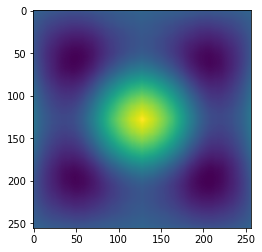

In [11]:
plt.imshow(a[0])

In [12]:
gradient_layers = []
depth = 4
for i in range(depth):
#     m_op = TF_nufft()
    m_op = NUFFT_op_TF()
    
    nd, kd = (Nd[0]//2**i, Nd[1]//2**i), (Kd[0]//2**i, Kd[1]//2**i)
    print(nd, kd)
    sel = np.linalg.norm(uv, axis=1) < np.pi / 2**i
    m_op.plan(uv[sel], nd, kd, Jd, 2)
    gradient_layers.append( Gradient(m_op, [None, nd[0], nd[1]], [None, np.sum(sel)], i, True) )

 10%|█████▉                                                        | 427/4440 [00:00<00:00, 4266.14it/s]

(256, 256) (512, 512)


 12%|███████▌                                                      | 541/4414 [00:00<00:00, 5400.75it/s]

(128, 128) (256, 256)


 18%|███████████▍                                                  | 545/2960 [00:00<00:00, 5444.46it/s]

(64, 64) (128, 128)


 36%|██████████████████████▌                                       | 539/1480 [00:00<00:00, 5383.05it/s]

(32, 32) (64, 64)


100%|█████████████████████████████████████████████████████████████| 1480/1480 [00:00<00:00, 5377.30it/s]


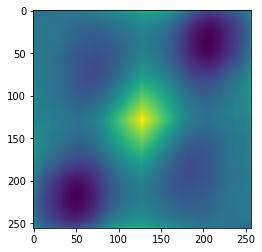

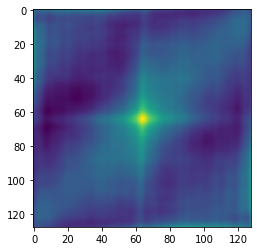

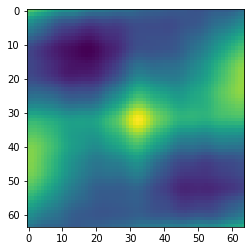

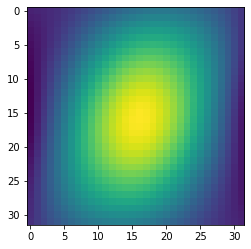

In [13]:
for i in range(depth):
    x_tf = tf.convert_to_tensor(np.ones((2, Nd[0]//2**i, Nd[1]//2**i)))
    y_tf = tf.cast(tf.convert_to_tensor(0j + np.ones((2,np.sum(np.linalg.norm(uv, axis=1) < np.pi / 2**i)))), tf.complex64)

    plt.imshow(gradient_layers[i](x_tf, y_tf).numpy().real[0])
    plt.show()

# simple test

In [14]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [15]:
class Unet(tf.keras.Model):
    def __init__(self, input_shape, uv, depth=2, start_filters=16, conv_layers=1, kernel_size=3, conv_activation='relu', output_activation='linear', grad=False):
        grad_on_upsample = True
        learned_grad = True

        batch_size = 2
        self.is_adapted=False
        inputs = tf.keras.Input(input_shape)
        
        x = inputs
        skips = []
        
        Nd = (input_shape[0], input_shape[1])
        Kd = (Nd[0]*2, Nd[1]*2)
        Jd = (6,6)

        if grad:
            inputs2 = tf.keras.Input([len(uv),1], dtype=tf.complex64) # individual measurements
            # construct gradient operators
            gradient_ops = []
            subsampled_inputs = []
    

            for i in range(depth):
#                 m_op = TF_nufft() # numpy function tf operator
                m_op = NUFFT_op_TF() # TF native operator
                nd, kd = (Nd[0]//2**i, Nd[1]//2**i), (Kd[0]//2**i, Kd[1]//2**i)
                sel = np.linalg.norm(uv, axis=1) < np.pi / 2**i
                m_op.plan(uv[sel], nd, kd, Jd, batch_size)
                gradient_ops.append( Gradient(m_op, [None, nd[0], nd[1]], [None, np.sum(sel)], i, learned_grad) )
                subsampled_inputs.append(tf.boolean_mask(inputs2, sel, axis=1))


        # convolution downward
        for i in range(depth):
            
            shape = (None, Nd[0]//2**i, Nd[1]//2**i)
            
            if grad:
                # gradients
                with tf.name_scope("Grad_" +str(i)):
                    gradi = gradient_ops[i](x[:,:,:,0], subsampled_inputs[i][:,:,0])
                    gradi.set_shape(shape)
                    x = tf.keras.layers.Concatenate()([x, gradi[:,:,:, None]])
            
            
            for j in range(conv_layers):
                x = tf.keras.layers.Conv2D(
                    filters=start_filters*2**(i), 
                    kernel_size=kernel_size, 
                    activation=conv_activation, 
                    padding='same',
                    name="conv2d_down_depth_" + str(i) + "_" + str(j)
                )(x)
                x = tf.keras.layers.BatchNormalization(
                    name="BatchNorm_down_depth_" + str(i) + "_" + str(j)
                )(x)
            skips.append(x)
            x = tf.keras.layers.MaxPool2D(padding='same')(x)


        # smallest layer
        for i in range(conv_layers):
            x = tf.keras.layers.Conv2D(
                    filters=start_filters*2**depth, 
                    kernel_size=kernel_size, 
                    activation=conv_activation, 
                    padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)



        # convolutions upward
        for i in range(depth):
            shape = (None, Nd[0]//2**(depth-i-1), Nd[1]//2**(depth-i-1))

            x = tf.keras.layers.UpSampling2D()(x)

            if grad and grad_on_upsample:
                # gradients
                with tf.name_scope("Grad_up_" +str(i)):
                    gradi = gradient_ops[-(i+1)](x[:,:,:,0], subsampled_inputs[-(i+1)][:,:,0])
                    gradi.set_shape(shape)
                    x = tf.keras.layers.Concatenate()([x, gradi[:,:,:, None]])
            
            x = tf.keras.layers.Concatenate()([x,skips[-(i+1)]])


            for j in range(conv_layers):
                x = tf.keras.layers.Conv2D(
                    filters=start_filters*2**(depth-(i+1)), 
                    kernel_size=kernel_size, 
                    activation=conv_activation, 
                    padding='same',
                    name="conv2d_up_depth_" + str(i) + "_" + str(j)
                )(x)
                x = tf.keras.layers.BatchNormalization(
                    name="BatchNorm_up_depth_" + str(i) + "_" + str(j)
                )(x)
                        
        # output formatting
        outputs = tf.keras.layers.Conv2D(
                    filters=1, 
                    kernel_size=1, 
                    padding='same',
                    activation=output_activation,
                    name="conv2d_output"
                    )(x)

        if grad:
            super().__init__(inputs=[inputs, inputs2], outputs=outputs)
        else:
            super().__init__(inputs=[inputs], outputs=outputs)

        self.compile(optimizer='adam', loss= tf.keras.losses.MSE)

In [16]:
model = Unet(input_shape=(256,256,1), uv=uv, depth=2, start_filters=4, conv_layers=1, kernel_size=3, conv_activation='relu', output_activation='linear', grad=True)


100%|█████████████████████████████████████████████████████████████| 4414/4414 [00:00<00:00, 5263.23it/s]


In [17]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
tf_op_layer_Grad_0/strided_slic [(None, 256, 256)]   0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Grad_0/Cast (Tensor [(None, 256, 256)]   0           tf_op_layer_Grad_0/strided_slice[
__________________________________________________________________________________________________
tf_op_layer_Grad_0/truediv (Ten [(None, 256, 256)]   0           tf_op_layer_Grad_0/Cast[0][0]    
_______________________________________________________________________________________________

In [18]:
x, y = np.ones((2,256,256,1)), np.ones((2,4440,1)) +0j

In [19]:
model.fit((x, y), x, batch_size=2, epochs=3)

Train on 2 samples
Epoch 1/3
2/2 [==============================] - 5s 3s/sample - loss: 2.1131
Epoch 2/3
2/2 [==============================] - 2s 942ms/sample - loss: 1.7193
Epoch 3/3
2/2 [==============================] - 2s 937ms/sample - loss: 1.5865
